In [2]:
# importazione delle librerie
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from itertools import combinations, permutations

import Lib.Funtions as fn
from Lib.Path import PATH_ESTR

# importiamo il path

In [3]:
# upload arhivio
fn.update_archivio()

CREIAMO LA NOSTRA CLASSE PER IL GIOCO DEL LOTTO

In [4]:
# funzione per dire quando e' uscito un numero
def uscite(df, numero):
    # prendiamo l'indice della riga che contiene un valore in una determinata colonna
    # la variabile numero e' una lista di numeri
    numeri = np.array(numero)
    uscite = np.array([])

    # se il numero di numeri e' 1
    if len(numeri) == 1:
        for i in df.columns[2:]:
            # aggiungi l'indice della riga che contiene il valore del numero nella colonna i
            uscite = np.append(uscite, df[df[i] == str(numeri[0])].index.values.astype(int))

    # se il numero di numeri e' maggiore di 1
    elif len(numeri) > 1:

        for i in range(len(df)):
            # prendiamo la riga i-esima con le colonne dalla 2 alla 8
            riga = df.iloc[i, 2:]
            
            # preniamo tutte le possibili combianzioni di numeri e le mettiamo in una lista
            # e poi verifichiamo se sono uscite
            for j in permutations(riga, len(numeri)):
                
                # convertiamo l´array numeri in una turpla di stringhe
                numeri = tuple(map(str, numeri))
                if j == numeri:
                    # se sono uscite, aggiungiamo l'indice della riga alla lista uscite
                    uscite = np.append(uscite, i)
                     
    
    # aggiungiamo ad ogni valore della lista il valore 1
    #uscite = np.sort(uscite + 1)
    uscite = np.sort(uscite)
    return uscite


In [5]:
def ritardi(df, numero):

    # calcoliamo le uscite
    u = uscite(df, numero)
    # calcuiamo la differenza tra ogni valore della lista e il successivo
    ritardi = np.diff(u)
    # inseriamo al primo posto il valore 0
    ritardi = np.insert(ritardi, 0, 0)

    return ritardi

In [6]:
# Funzione per plottare i grafici
def plot_graph(pf):

    pf = pf.astype(float)
    plt.rcParams["figure.figsize"] = (36, 30)
    # plt.rcParams["savefig.format"] = 'png'  

    # plotting di tutte le curve 
    plt.plot(pf['close'][:], color='blue', label='Scompensazione')
    # plotting zigzag che è un grafico linee di punti
    #plt.plot(pf.index, pf["zigzag"], label="zigzag", color='black', linewidth=1)

    # plotting medie mobili
    plt.plot(pf["SMA_10"][:], color='red', label='SMA_10')
    plt.plot(pf["SMA_30"][:], color='green', label='SMA_30')

    # configuraione degli assi
    plt.xlabel('Numero uscita', fontsize=18)
    plt.ylabel('Scompensazione', fontsize=18)

    # configurazioni del titolo, leggende, griglia
    plt.title('GRAFICO', fontsize=20)
    plt.legend()
    plt.grid()
    plt.show()

In [47]:
# creiamo una funzione per calcolare e massimi e minimi relativi per fare un grafico a zigzag
def zigzag(df, percentage):
    """
    Calcola l'indicatore ZigZag su una colonna di un DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame contenente i dati
        column_name (str): Nome della colonna da analizzare
        percentage (float): Soglia percentuale per identificare i pivot (es. 5 per 5%)
    
    Returns:
        list: Lista di tuple (indice, valore, tipo) dove tipo è 'High' o 'Low'
    """
    # Estrai la colonna come lista di valori
    data = df["close"].tolist()
    
    if not data or len(data) < 2:
        return []

    zigzag_points = []
    last_pivot = data[0]
    last_pivot_index = 0
    direction = None  # None: iniziale, 1: crescente, -1: decrescente

    for i in range(1, len(data)):
        value = data[i]
        
        # Calcola la variazione percentuale rispetto all'ultimo pivot
        # Evita divisione per zero usando un valore piccolo se last_pivot è 0
        if last_pivot == 0:
            change = float('inf') if value != 0 else 0
        else:
            change = abs((value - last_pivot) / last_pivot * 100)
        
        if change >= percentage:
            if direction is None:
                # Primo pivot dopo l'inizio
                if value > last_pivot:
                    zigzag_points.append((last_pivot_index, last_pivot, "Low"))
                    direction = 1
                elif value < last_pivot:
                    zigzag_points.append((last_pivot_index, last_pivot, "High"))
                    direction = -1
                last_pivot = value
                last_pivot_index = i
                
            elif direction == 1 and value < last_pivot:
                # Cambio da crescente a decrescente
                zigzag_points.append((last_pivot_index, last_pivot, "High"))
                direction = -1
                last_pivot = value
                last_pivot_index = i
                
            elif direction == -1 and value > last_pivot:
                # Cambio da decrescente a crescente
                zigzag_points.append((last_pivot_index, last_pivot, "Low"))
                direction = 1
                last_pivot = value
                last_pivot_index = i
                
            elif (direction == 1 and value > last_pivot) or (direction == -1 and value < last_pivot):
                # Aggiorna il pivot se continua nella stessa direzione
                last_pivot = value
                last_pivot_index = i

    # Aggiungi l'ultimo punto se significativo
    if last_pivot_index != len(data) - 1:
        last_value = data[-1]
        if last_pivot == 0:
            change = float('inf') if last_value != 0 else 0
        else:
            change = abs((last_value - last_pivot) / last_pivot * 100)
        if change >= percentage:
            zigzag_points.append((last_pivot_index, last_pivot, "High" if direction == 1 else "Low"))

    return zigzag_points


In [7]:
class Lotto:

    def __init__(self, path=PATH_ESTR):
        """Di default il path e' la cartella estrazioni"""
        self.ruota = None
        self.df = None
        self.numero = None
        self.path = path

    def carica_estrazioni(self, ruota):
        """Carica le estrazioni di una ruota in un dataframe"""
        r = self.path+ruota+'.csv'
        estrazioni = fn.leggi_da_csv(r)
        df = pd.DataFrame(estrazioni[1:], columns=estrazioni[0])
        # eliminiamo le righe duplicate
        df.drop_duplicates(inplace=True)
        self.ruota = ruota
        return df

    def carica_numero(self, numero, df, n_estr=10):
        """
        Elabora le informazioni statistiche sul numero e sui numeri inseiriti
        Il numero va inserito come [] di numeri interi
        """
        self.df = df
        self.n_estr = n_estr
        self.numero = numero
        # il totale delle estrazioni e' dato dalla lunghezza del dataframe
        self.totale_estrazioni = len(self.df)
        # calcoliamo le posizioni di indice delle uscite del numero
        self.elenco_uscite = uscite(self.df, self.numero)
        # il numero totali delle volte che e' uscito e' dato dalla lunghezza della lista
        self.n_uscite = len(self.elenco_uscite)
        if self.n_uscite > 0:
            # il vettore delle frequenze e' dato dal vettore del numero di uscite diviso il vettore dell'indice del vettore stesso + 1
            self.frequenze = self.elenco_uscite / (np.arange(len(self.elenco_uscite))+1)
            # la frequenza media (ultima frequenza o frequenza attuale) e' data dal totale delle estrazioni diviso il numero di uscite
            self.ultima_frequenza = round(float(self.totale_estrazioni/self.n_uscite), 2)
            # l'elenco dei ritardi e' dato dal vettore dei ritardi
            self.ritardi = ritardi(self.df, self.numero)
            # il ritardo attuale e' dato dalla differenza tra il totale delle estrazioni e l'indice l'ultima uscita
            self.ritardo_attuale = self.totale_estrazioni - self.elenco_uscite[-1]
            # calcoliamo il ritardo massimo storico
            self.ritardo_massimo = self.ritardi.max()
            # salviamo l'ultimo ritardo
            self.ultimo_ritardo = self.ritardi[-1]
            # calcoliamo la scompensazione
            self.scompensazioni = self.ritardi - self.frequenze
            # calcoliamo la scompensazione attuale e l'ultima scompensazione
            self.ultima_scompensazione = self.scompensazioni.sum()
            self.scompensazione_attuale = self.ultima_scompensazione + (self.ritardo_attuale - self.ultima_frequenza)     
            # calcoliamo le spie
            self.spia_num, self.spia_rip = self.spia()
            # salviamo le statistiche in un dizionario
        else:
            self.frequenze = np.nan
            self.ultima_frequenza = np.nan
            self.ritardi = np.nan
            self.ritardo_attuale = np.nan
            self.ritardo_massimo = np.nan
            self.ultimo_ritardo = np.nan
            self.scompensazioni = np.nan
            self.ultima_scompensazione = np.nan
            self.scompensazione_attuale = np.nan
            self.spia_num, self.spia_rip, self.spia_estr = np.nan, np.nan, np.nan
            print(f'{self.numero}, non è mai uscito')

        self.statistiche = {
            'ruota': self.ruota,
            'numero': self.numero,
            'n_uscite': self.n_uscite,
            'totale_estrazioni': self.totale_estrazioni,
            'ultima_frequenza': self.ultima_frequenza,
            'ritardo_attuale': self.ritardo_attuale,
            'ritardo_massimo': self.ritardo_massimo,
            'ultimo_ritardo': self.ultimo_ritardo,
            'ultima_scompensazione': self.ultima_scompensazione,
            'scompensazione_attuale': self.scompensazione_attuale,
            'spia_num': self.spia_num,
            'spia_rip': self.spia_rip,
            'spia_estr': self.n_estr
        }
        
    def stampa_statistihe(self):
        
        for k, v in self.statistiche.items():
            print(f'{k}: {v}')

    def spia(self):
        t = np.array([])
        for i in self.elenco_uscite:
            i = int(i) - 2
            t = np.append(t, self.df.iloc[i-self.n_estr:i, 2:].values)
        pf = pd.DataFrame(columns=['n_spia', 'rip'])
        pf['n_spia'], pf['rip'] = np.unique(t.flatten(), return_counts=True)
        pf.sort_values(by=['rip'], inplace=True)
        u, c = pf.iloc[-1]
        return u, c
    
    def calcolo_zigzag(self, percentage):
        """
        Calcola il grafico a zigzag
        """

        # Calcola i punti ZigZag
        zigzag_result = zigzag(self.df_trend, percentage)

        # salviamo i punti ZigZag nel dataframe
        self.df_trend['zigzag'] = np.nan
        for index, value, pivot_type in zigzag_result:
            self.df_trend.loc[index, 'zigzag'] = value

        
        # Stampa i risultati
        print("Punti ZigZag trovati:")
        for point in zigzag_result:
            index, value, pivot_type = point
            timestamp = self.df_trend["close"].iloc[index]
            print(f"Indice: {index}, Timestamp: {timestamp}, Valore: {value}, Tipo: {pivot_type}")
        

    def calcolo_trend(self):

        l10 = 10
        l30 = 30 

        try:
            # utilizzo le funzioni di pandas_ta per calcolare il trend della scompensazione
            self.df_trend = pd.DataFrame()
            self.df_trend['scompensi'] = self.scompensazioni
            # aggiungo la colonna close perche' la funzione ta.sma la richiede
            self.df_trend['close'] = self.df_trend['scompensi'].cumsum()
            sma10 = self.df_trend.ta.sma(length=l10)
            sma30 = self.df_trend.ta.sma(length=l30)
            self.df_trend = pd.concat([self.df_trend, sma10, sma30], axis=1)
            self.df_trend['scomp_sigLine'] = np.where(self.df_trend['SMA_10'] > self.df_trend['SMA_30'], 1, 0 )
            self.df_trend['scomp_position'] = self.df_trend['scomp_sigLine'].diff()
            self.df_trend["Status"] = np.where(self.df_trend['scomp_sigLine'] == 0, 'F', 'R')
            self.trend = self.df_trend['Status'].iloc[-1]
            self.statistiche['trend'] = self.trend

        except:
            print('Impossibile calcolare il trend')
            self.statistiche['trend'] = np.nan

    def print_trend(self):
        if self.statistiche['trend'] is not np.nan:
            plot_graph(self.df_trend[['close', 'SMA_10', 'SMA_30']])
        #print(self.df_trend.columns)

    def previsioni(self, ruota):

        temp = self.carica_estrazioni(ruota)
        df = pd.DataFrame()

        # calcoliamo le previsioni
        for i in range(1, 91):

            self.carica_numero([i], temp)
            self.calcolo_trend()
            nuovo_df = pd.DataFrame([self.statistiche])
            df = pd.concat([df, nuovo_df], ignore_index=True)
            #df = df.append(self.statistiche, ignore_index=True)
        
        df = df[(df['ritardo_attuale'] < 15) & (df['scompensazione_attuale'] < 0) & (df['trend'] == 'F')].sort_values(by='ultima_frequenza', ascending=False)
        self.previsione = df['numero'].values
        # stampiamo le previsioni con un ciclo for
        lista = []
        for i in range(len(self.previsione)):
            lista.append(self.previsione[i])
        print(f"i numeri da giocare su {ruota} sono: {lista}")
        #return f"i numeri da giocare su {ruota} sono: {self.previsione}"
        
            


In [8]:
def calcola_uscita_da_spia(spia, ruota, n_estr=20):
    temp = Lotto()
    df_temp = temp.carica_estrazioni(ruota)
    temp.carica_numero([spia], df_temp, n_estr)
    #print(f"spia: {spia}, n_estr: {n_estr}")
    # calcoliamo le uscite
    x = int(temp.elenco_uscite[-1]) - 1
    #print(f"uscita: {temp.elenco_uscite[-1]} uscita -1 : {x}")
    #print(f"return: {len(df_temp) - x}")
    return len(df_temp) - x



In [9]:
# creiamo una lista in numpy con tutti gli ambi in 90 numeri
numeri = np.arange(1,91)
ambi = np.array(list(combinations(numeri,2)))
print(len(ambi))

4005


In [ ]:
# creiamo in dataframe contenenti tutti gli ambi e il loro numero spia a 5, 10 e 20 estrazioni
dataframe = pd.DataFrame(columns=['Ambi', 'uscite', 'Spia10', 'rip10', 'tra10','Spia20', 'rip20', 'tra20'])
n = Lotto()
ruota = 'BA'
estrazioni = n.carica_estrazioni(ruota)

for i in ambi:
    i = list(map(int, i))
    #print(f"Coppia di numeri: {i}")
    n.carica_numero(i, estrazioni, 10)
    n_uscite = n.n_uscite
    spia10 = n.spia_num
    rip10 = n.spia_rip
    # calcoliamo il ritardo dell'uscita della spia (se è negativa significa che è in ritardo)
    tra10 = 10 - calcola_uscita_da_spia(spia10, ruota, 10)
    n.carica_numero(i, estrazioni, 20)
    spia20 = n.spia_num
    rip20 = n.spia_rip
    # calcoliamo il ritardo dell'uscita della spia (se è negativa significa che è in ritardo)
    tra20 = 20 - calcola_uscita_da_spia(spia20, ruota, 20)

    nuova_riga = pd.DataFrame({
        'Ambi': [i],
        'uscite': [n_uscite],
        'Spia10': [spia10],
        'rip10': [rip10],
        'tra10': [tra10],
        'Spia20': [spia20],
        'rip20': [rip20],
        'tra20': [tra20]
    })

    dataframe = pd.concat([dataframe, nuova_riga], ignore_index=True)

    # salviamo in un file csv in modalità append
    dataframe.to_csv(PATH_ESTR+'ambi.csv', mode='w', index=False, header=True)

"""     dataframe = dataframe.append({
        'Ambi': i, 
        'uscite': n_uscite, 
        'Spia10': spia10, 'rip10': rip10, 'tra10': tra10,
        'Spia20': spia20, 'rip20': rip20, 'tra20': tra20
        }, ignore_index=True) """

dataframe.head(100)

i numeri da giocare su MI sono: [[87], [21], [72], [6], [61], [73], [27], [70], [33], [69], [86], [20], [8], [51], [80]]
ruota: MI
numero: [87]
n_uscite: 368
totale_estrazioni: 7085
ultima_frequenza: 19.25
ritardo_attuale: 2.0
ritardo_massimo: 103.0
ultimo_ritardo: 8.0
ultima_scompensazione: -329.1192316505424
scompensazione_attuale: -346.3692316505424
spia_num: 90
spia_rip: 252
spia_estr: 10
trend: F


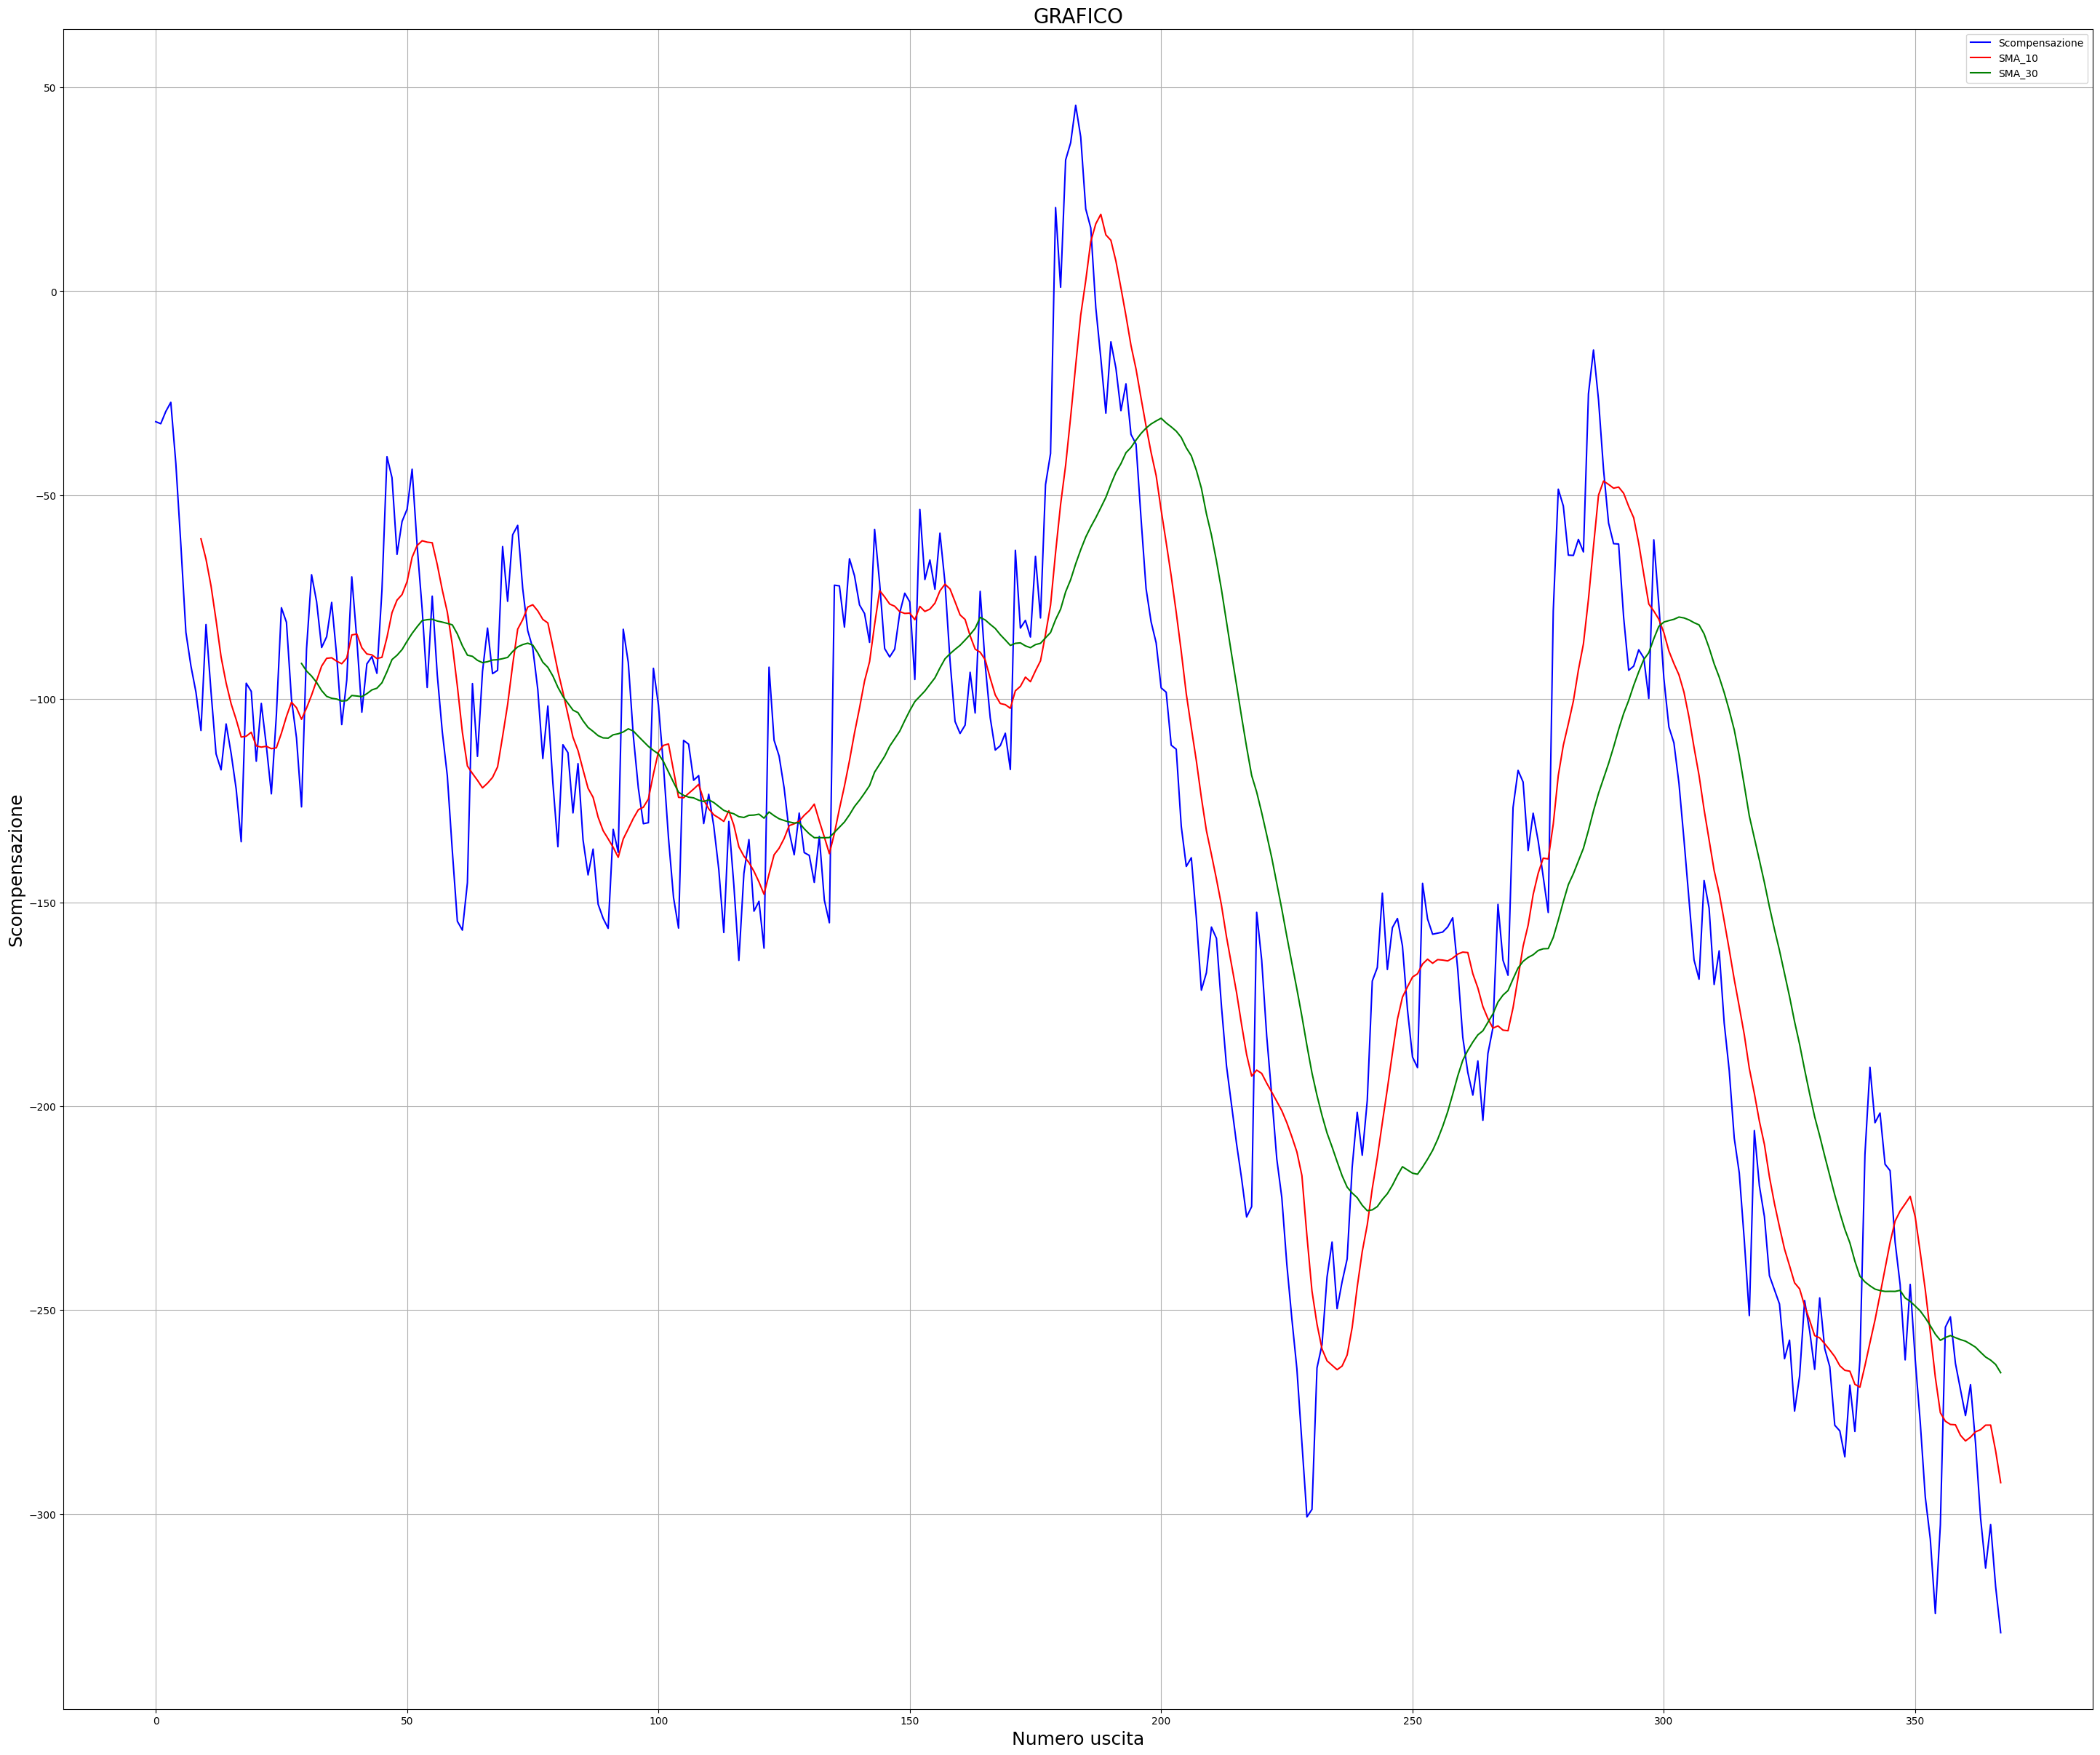

In [11]:
ambo = Lotto()
ambo.previsioni('MI')
df = ambo.carica_estrazioni('MI')
ambo.carica_numero([87], df, 10)
ambo.calcolo_trend()
#ambo.calcolo_zigzag(40)
ambo.stampa_statistihe()
ambo.print_trend()